# Problema da Mochila

In [265]:
import random
import copy
import matplotlib.pyplot as plt
import pandas as pd
from typing import List
import numpy as np

## Definição do Problema
Você fará uma viagem a um acampamento durante o final de semana e precisa decidir quais itens levar. Como você só dispõe de uma mochila com capacidade para 15 kg, decidiu incluir somente os itens que maximizem a soma do valor em R$ dos itens, sem ultrapassar o limite de peso.  
Resolva o problema utilizando algoritmo genético. Para isso descreva a forma de representação do problema em cromossomos, a função de ajuste (fitness) e os operadores genéticos (mutação, crossover e o mecanismo de seleção).  
Assuma valores razoáveis para os hiperparâmetros comentando a sua escolha. Depois experimente alterá-los e reporte o que acontece  

O problema da mochila é um problema clássico de programação dinâmica, e para o nosso caso em específico ao implementar um algoritmo de programação dinâmica temos que o valor máximo possível de ser levado é de 870.  

In [266]:
# Criando a classe item para ficar empacotar as informações dos itens e acessar de forma padronizada
class Item:
    def __init__(self, name, weight, value):
        self.name = name
        self.weight = weight
        self.value = value

In [267]:
items = [
    Item("Barraca", 3.5, 150.00),
    Item("Saco de dormir", 2.0, 100.00),
    Item("Isolante térmico", 0.5, 50.00),
    Item("Colchão inflável", 1.0, 80.00),
    Item("Lanterna", 0.2, 30.00),
    Item("Kit de primeiros socorros", 0.5, 20.00),
    Item("Repelente de insetos", 0.1, 15.00),
    Item("Protetor solar", 0.2, 20.00),
    Item("Canivete", 0.1, 10.00),
    Item("Mapa e bússola", 0.3, 25.00),
    Item("Garrafa de água", 1.8, 15.00),
    Item("Filtro de água", 0.5, 50.00),
    Item("Comida (ração liofilizada)", 3.0, 50.00),
    Item("Fogão de camping", 1.5, 70.00),
    Item("Botijão de gás", 1.2, 30.00),
    Item("Prato, talheres e caneca", 0.5, 20.00),
    Item("Roupas (conjunto)", 1.5, 80.00),
    Item("Calçados (botas)", 2.0, 120.00),
    Item("Toalha", 0.5, 20.00),
    Item("Kit de higiene pessoal", 0.5, 30.00)
]

# Resolução por Programação Dinâmica

In [268]:
# Código obtido com ajuda do Chat GPT, como não é o foco do projeto, utilizamos nesse caso para avaliar se a solução
# estava indo no caminho certo.  
def knapsack_dynamic(values, weights, capacity):
    n = len(values)
    dp = [0] * (capacity + 1)

    for i in range(n):
        for w in range(capacity, weights[i] - 1, -1):
            dp[w] = max(dp[w], dp[w - weights[i]] + values[i])

    return dp[capacity]


values = [item.value for item in items]
weights = [int(item.weight*10) for item in items]
capacity = 150
print(knapsack_dynamic(values, weights, capacity))

870.0


## Cromossomos

Vamos criar o cromossomo como uma classe, onde poderemos definir seu tamanho, dessa forma o tamanho do cromossomo poderá ser utilizado como um hiperparametro.  
Vamos também definir como método uma função fitness, podendo assim calcular qual seu fitness

In [269]:
class Chromosome:
    def __init__(self, items, max_weight, warm_start=True, random_state=None):
        self.length = len(items)
        self.items = items
        self.max_weight = max_weight
        self.random_state = random_state
        self._init_genes(warm_start=warm_start)
        
    def _init_genes(self, warm_start):
        if warm_start:
            random.seed(self.random_state)
            self.genes = [random.randint(0,1) for _ in range(self.length)]
        else:
            self.genes = [0 for _ in range(self.length)]

    def get_metrics(self):

        self.weight = sum([self.items[index].weight for index, gene in enumerate(self.genes) if gene == 1])

        if self.weight <= self.max_weight:
            self.fitness = sum([self.items[index].value for index, gene in enumerate(self.genes) if gene == 1])
        else:
            self.fitness = 0

        return self.fitness, self.weight

    # Os métodos abaixo são implementados para facilitar a comparação entre diferentes cromossomos
    def __eq__(self, other):
        if isinstance(other, Chromosome):
            return self.fitness == other.fitness
        return NotImplemented

    def __lt__(self, other):
        if isinstance(other, Chromosome):
            return self.fitness < other.fitness
        return NotImplemented

    def __le__(self, other):
        if isinstance(other, Chromosome):
            return self.fitness <= other.fitness
        return NotImplemented

    def __gt__(self, other):
        if isinstance(other, Chromosome):
            return self.fitness > other.fitness
        return NotImplemented

    def __ge__(self, other):
        if isinstance(other, Chromosome):
            return self.fitness >= other.fitness
        return NotImplemented


In [270]:
# Testando Criação dos Genes e verificando random_state para replicabilidade
print('With random state: ', Chromosome(items, 15, random_state=777).genes)
print('With random state: ', Chromosome(items, 15, random_state=777).genes)
print('Without random state: ', Chromosome(items, 15).genes)
print('Without random state: ', Chromosome(items, 15).genes)
print('Without random state: ', Chromosome(items, 15, warm_start=False).genes)
print('Without random state: ', Chromosome(items, 15, warm_start=False).genes)

With random state:  [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
With random state:  [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Without random state:  [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]
Without random state:  [0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]
Without random state:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Without random state:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Operadores
Agora vamos criar funções capazes de realizar as seguintes ações:  
- Crossover
- Mutação

### Crossover
Na função de crossover implementada estamos utilizando um sorteio com probabildiade de 50% para selecionar quais genes do cromossomo 1 serão trocados com o do cromossomo 2.  
Após essa definição sorteamos a mesma quantidade de genes do cromossomo 2 para sofrerem o crossover

In [271]:
def crossover(chromosome_x, chromosome_y, crossover_prob,random_state = None):
    random.seed(random_state)
    genes_to_crossover_x = [i for i in range(chromosome_x.length) if random.uniform(0,1) <= crossover_prob]

    genes_to_crossover_y = list(range(chromosome_y.length))
    random.seed(random_state)
    random.shuffle(genes_to_crossover_y)
    genes_to_crossover_y = genes_to_crossover_y[:len(genes_to_crossover_x)]

    chromosome_crossover = copy.deepcopy(chromosome_x)
    for x, y in zip(genes_to_crossover_x, genes_to_crossover_y):
        chromosome_crossover.genes[x] = chromosome_y.genes[y]

    return chromosome_crossover

In [272]:
x, y = Chromosome(items, 15), Chromosome(items, 15)

In [273]:
x.genes, y.genes

([1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1],
 [1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [274]:
crossover(x, y, 0.7).genes

[1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0]

### Mutação
Para mutação estamos usando uma taxa fixa de 50% de chance de cada gene do cromossomo ser alterado

In [275]:
def mutate(chromosome, mutation_prob, random_state=None):
    random.seed(random_state)
    mutated_chromosome = copy.deepcopy(chromosome)
    mutated_chromosome.genes = [(gene+1)%2 if random.uniform(0,1) <= mutation_prob else gene for gene in chromosome.genes]

    return mutated_chromosome

In [276]:
x.genes

[1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]

In [277]:
mutate(x, 0.5, 777).genes

[0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1]

### Seleção
Vamos também criar uma forma para seleção dos cromossomos entre gerações, para isso vamos utilizar uma seleção por roleta dos pais e depois realizar crossover para criação de novos cromossomos filhos, assim como a mutação desses novos cromossomos filhos.  
Para esse método de seleção deixaremos algumas informações parametrizaveis para que possam ser alteradas e hipertunadas, como:  
- Quantidade de pais na próxima geração  
- Probabilidade de mutação de um gene  
- Probabilidade de Crossover de um gene

#### Roleta
Estamos realizando uma seleção dos pais por roleta, utilizando seu fitness como probabilidade para serem selecionados

In [278]:
def roulette_selection(chromosomes, fathers_next_gen, random_state=None):
    fitness_prob = [chromosome.get_metrics()[0] for chromosome in chromosomes]

    # Somando + 1 por conta de divisões por 0 devido a warm_start=False
    fitness_prob = [(fitness+1)/(sum(fitness_prob)+1) for fitness in fitness_prob]

    random.seed(random_state)
    fitness_prob = sorted([(fitness*random.uniform(0,1), index) for index, fitness in enumerate(fitness_prob)], reverse=True)
    fathers_chromosomes = [chromosomes[fitness_prob[index][1]] for index in range(fathers_next_gen)]

    return fathers_chromosomes

In [279]:
roulette_selection([x, y, x, y, x, y, y, y, y], 5, 777)

In [280]:
def select(chromosomes, fathers_next_gen, mutation_prob, crossover_prob, random_state=None):

    fathers_chromosomes = roulette_selection(chromosomes, fathers_next_gen, random_state)
    qty_childs = len(chromosomes) - len(fathers_chromosomes)

    # crossover
    childs_chromosomes = []
    for _ in range(qty_childs):
        random.seed(random_state)
        chromosome_x = chromosomes[random.randint(0,len(chromosomes)-1)]
        random.seed(random_state)
        chromosome_y = chromosomes[random.randint(0,len(chromosomes)-1)]
        childs_chromosomes.append(crossover(chromosome_x, chromosome_y, crossover_prob, random_state))

    # child mutation
    for index, child_chromosome in enumerate(childs_chromosomes):
        childs_chromosomes[index] = mutate(child_chromosome, mutation_prob, random_state)

    return fathers_chromosomes + childs_chromosomes

In [281]:
chromosomes = [
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15),
    Chromosome(items, 15)
]

In [282]:
# 10 cromossomos, elitismo com 5 pais por roleta, 0.1% de probabilidade de mutação, 0.6% de probabilidade de crossover
select(chromosomes, 5, 0.1, 0.6, 777)

## Log Data
Também será necessário salvar os dados, para que possamos observar a evolução da solução ao longo das gerações.  

In [283]:
def log_data(epoch, chromosomes, fathers_next_gen, mutation_prob, crossover_prob, warm_start, random_state):
    for chromosome in chromosomes:
        chromosome.get_metrics()
        
    best_chromosome = max(chromosomes)
    avg_fitness = np.mean([chromosome.fitness for chromosome in chromosomes])
    print_log = f'''Epoch: {epoch} - Fitness: {best_chromosome.fitness} - Chromossome: {best_chromosome.genes}'''
    data_log = [epoch, best_chromosome.fitness, avg_fitness, best_chromosome.genes, len(chromosomes), fathers_next_gen, mutation_prob, crossover_prob, warm_start, random_state]

    print(print_log)
    return data_log    

## Evolução
Para evoluir a solução, vamos precisar de uma estrutura de repetição.

In [284]:
def evolve(epochs, chromosomes_len, fathers_next_gen, mutation_prob, crossover_prob, warm_start=False, random_state=None):

    random.seed(random_state)
    chromosomes = [
        Chromosome(items, 15, 
                   warm_start=warm_start,
                   random_state=random.randint(0, int(1e9))) for _ in range(chromosomes_len)
    ]

    data_log = []
    for epoch in range(epochs):
        data_log.append(log_data(epoch, chromosomes, fathers_next_gen, mutation_prob, crossover_prob, warm_start, random_state))
        chromosomes = select(chromosomes, fathers_next_gen, mutation_prob, crossover_prob, random_state)

    best_chromosome = max(chromosomes, key=lambda x: x.get_metrics()[0])
    return best_chromosome, data_log


In [285]:
# Exibir o melhor conteúdo da mochila
def print_best_knapsack(chromosome):
    print("\nMelhor solução encontrada:")
    total_weight = 0
    total_value = 0
    selected_items = []

    for gene, item in zip(chromosome.genes, chromosome.items):
        if gene == 1:
            selected_items.append((item.name, item.weight, item.value))
            total_weight += item.weight
            total_value += item.value

    for name, weight, value in selected_items:
        print(f"Item: {name} | Peso: {weight:.2f}kg | Valor: R${value:.2f}")

    print(f"\nPeso total: {total_weight:.2f}kg")
    print(f"Valor total: R${total_value:.2f}")

In [286]:
# Depois de um tempo ele ta parando de mudar, precisa entender o pq
# Ele ta evoluindo ao contrário, entender o pq tbm# Rodando o algoritmo e imprimindo os resultados
best_chromosome, data_log = evolve(1500, 200, 180, 0.01, 0.01)

Epoch: 0 - Fitness: 0 - Chromossome: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Epoch: 1 - Fitness: 120.0 - Chromossome: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Epoch: 2 - Fitness: 120.0 - Chromossome: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Epoch: 3 - Fitness: 140.0 - Chromossome: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Epoch: 4 - Fitness: 140.0 - Chromossome: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Epoch: 5 - Fitness: 140.0 - Chromossome: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Epoch: 6 - Fitness: 140.0 - Chromossome: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Epoch: 7 - Fitness: 175.0 - Chromossome: [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Epoch: 8 - Fitness: 175.0 - Chromossome: [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Epoch: 9 - Fitness: 175.0 - Chromossome: [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [287]:
print_best_knapsack(best_chromosome)


Melhor solução encontrada:
Item: Barraca | Peso: 3.50kg | Valor: R$150.00
Item: Saco de dormir | Peso: 2.00kg | Valor: R$100.00
Item: Isolante térmico | Peso: 0.50kg | Valor: R$50.00
Item: Colchão inflável | Peso: 1.00kg | Valor: R$80.00
Item: Lanterna | Peso: 0.20kg | Valor: R$30.00
Item: Kit de primeiros socorros | Peso: 0.50kg | Valor: R$20.00
Item: Repelente de insetos | Peso: 0.10kg | Valor: R$15.00
Item: Canivete | Peso: 0.10kg | Valor: R$10.00
Item: Mapa e bússola | Peso: 0.30kg | Valor: R$25.00
Item: Filtro de água | Peso: 0.50kg | Valor: R$50.00
Item: Fogão de camping | Peso: 1.50kg | Valor: R$70.00
Item: Prato, talheres e caneca | Peso: 0.50kg | Valor: R$20.00
Item: Roupas (conjunto) | Peso: 1.50kg | Valor: R$80.00
Item: Calçados (botas) | Peso: 2.00kg | Valor: R$120.00
Item: Kit de higiene pessoal | Peso: 0.50kg | Valor: R$30.00

Peso total: 14.70kg
Valor total: R$850.00


In [288]:
# DataFrame com os dados coletados
columns = ["Epoch", "Best_Fitness", "Avg_Fitness", "Best_Chromosome", "Population_Size", "Fathers_Next_Gen", "Mutation_Prob", "Crossover_Prob", "Warm_Start", "Random_State"]
df = pd.DataFrame(data_log, columns=columns)

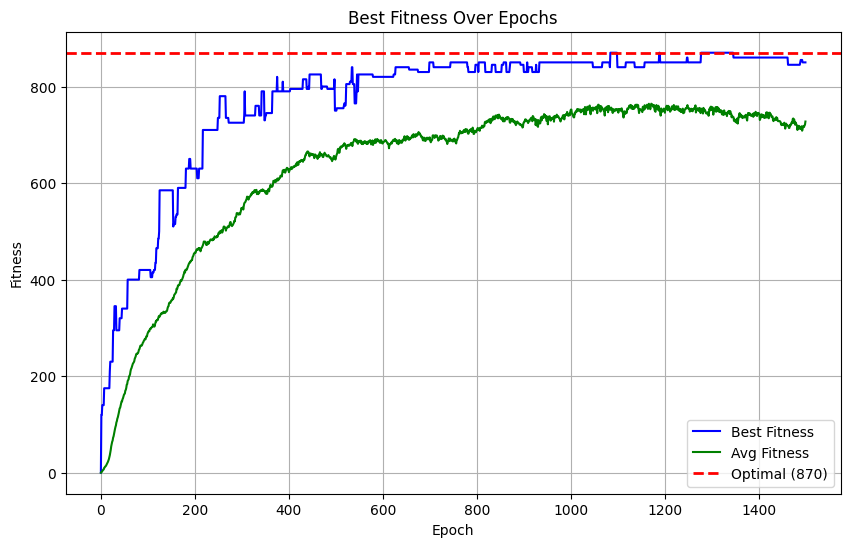

In [289]:
plt.figure(figsize=(10, 6))
plt.plot(df["Epoch"], df["Best_Fitness"], label="Best Fitness", color="blue")
plt.plot(df["Epoch"], df["Avg_Fitness"], label="Avg Fitness", color="green")
plt.axhline(y=870, color="red", linestyle="--", linewidth=2, label="Optimal (870)")
plt.xlabel("Epoch")
plt.ylabel("Fitness")
plt.title("Best Fitness Over Epochs")
plt.legend()
plt.grid()
plt.show()


Utilizando os métodos descritos acima, fomos capazes de executar 1 geração do algoritmo com os seguintes hiperparametros:  
- **Quantidade de Épocas/Iterações**: 1000 
- **Quantidade de Cromossomos**: 200
- **Quantidade de Pais entre Épocas/Iterações**: 180
- **Probabilidade de Mutação**: 1%
- **Probabilidade de Crossover**: 1%  
- **Warm Start**: False  
Com isso obtivemos o gráfico acima, mostrando a evolução do fitness do melhor cromossomo e a média dos cromossomos por época.  
É possível notar a evolução ao longo das épocas e como o método de seleção foi capaz de evoluir os cromossomos até o ponto ótimo (870), mas também é possível notar a aleatoriedade no processo evolutivo, mostrando que não é aleatório e não linear, mas também mostrando que é capaz de convergir para soluções ótimas.  

# Trocando os hiperparametros para testar novas combinações
Com um método capaz de testar diferentes hiperparametros, conseguimos comparar a evolução de diferentes experimentos, podendo testar quantidade de cromossomos, quantidade de pais, taxa de mutação, taxa de crossover e início rápido diferentes.  

In [290]:
def tune_hyperparams(test_configs):
    experiment_results = []
    
    for config in test_configs:
        print(f"Rodando experimento com a configuração: {config}")

        best_chromosome, data_log = evolve(
            epochs=config["geracoes"],
            chromosomes_len=config["cromossomos"],
            fathers_next_gen=int(config["quantidade_pais"]),
            mutation_prob=config["prob_mutacao"],
            crossover_prob=config["prob_crossover"],
            warm_start=config['inicio_rapido'],
            random_state=config["random_state"]
        )
        
        experiment_results.append({
            "config": config,
            "data_log": data_log,
            "best_fitness" : max([row[1] for row in data_log]),
            "best_chromosome": best_chromosome
        })
    
    # Ordenar os resultados pelos melhores, indipendente se esteve na última geração ou não.
    sorted_results = sorted(experiment_results, key=lambda x: x["best_fitness"], reverse=True)
    
    
    for result in sorted_results:
        print(f"Configuração: {result['config']} | Melhor Fitness: {result['best_fitness']}")
    
    return sorted_results

test_configs = [
    {"cromossomos": 200, "quantidade_pais": 180, "prob_mutacao": 0.01, "prob_crossover": 0.01, "geracoes": 1000, "inicio_rapido" : False, "random_state": None},
    {"cromossomos": 200, "quantidade_pais": 180, "prob_mutacao": 0.01, "prob_crossover": 0.01, "geracoes": 1000, "inicio_rapido" : True, "random_state": None},
    {"cromossomos": 200, "quantidade_pais": 180, "prob_mutacao": 0.05, "prob_crossover": 0.0, "geracoes": 1000, "inicio_rapido" : True, "random_state": None},
    {"cromossomos": 10, "quantidade_pais": 8, "prob_mutacao": 0.01, "prob_crossover": 0.01, "geracoes": 100, "inicio_rapido" : True, "random_state": None},
    {"cromossomos": 50, "quantidade_pais": 25, "prob_mutacao": 0.5, "prob_crossover": 0.5, "geracoes": 1000, "inicio_rapido" : False, "random_state": None},
    {"cromossomos": 80, "quantidade_pais": 10, "prob_mutacao": 0.1, "prob_crossover": 0.5, "geracoes": 350, "inicio_rapido" : True, "random_state": None}
]


experiment_results = tune_hyperparams(test_configs)


Rodando experimento com a configuração: {'cromossomos': 200, 'quantidade_pais': 180, 'prob_mutacao': 0.01, 'prob_crossover': 0.01, 'geracoes': 1000, 'inicio_rapido': False, 'random_state': None}
Epoch: 0 - Fitness: 0 - Chromossome: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Epoch: 1 - Fitness: 50.0 - Chromossome: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Epoch: 2 - Fitness: 215.0 - Chromossome: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
Epoch: 3 - Fitness: 215.0 - Chromossome: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
Epoch: 4 - Fitness: 215.0 - Chromossome: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
Epoch: 5 - Fitness: 215.0 - Chromossome: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
Epoch: 6 - Fitness: 215.0 - Chromossome: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
Epoch: 7 - Fitness: 270.0 - Chromossome: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

In [291]:
for result in experiment_results:
    print(f"Quantidade de cromossomos: {result['config']['cromossomos']}")
    print(f"Quantidade de pais: {result['config']['quantidade_pais']}")
    print(f"Probabilidade de mutação: {(result['config']['prob_mutacao']) * 100}%")
    print(f"Probabilidade de crossover: {result['config']['prob_crossover'] * 100}%")
    print(f"Quantidade de gerações: {result['config']['geracoes']}")
    print(f"Início rápido: {result['config']['inicio_rapido']}")
    print(f"Random state: {result['config']['random_state']}")
    print(f"Melhor Fitness: {result['best_fitness']}")

    print_best_knapsack(result['best_chromosome'])

    print("\n----------------------------------------------------------------------------------\n")

Quantidade de cromossomos: 50
Quantidade de pais: 25
Probabilidade de mutação: 50.0%
Probabilidade de crossover: 50.0%
Quantidade de gerações: 1000
Início rápido: False
Random state: None
Melhor Fitness: 870.0

Melhor solução encontrada:
Item: Barraca | Peso: 3.50kg | Valor: R$150.00
Item: Saco de dormir | Peso: 2.00kg | Valor: R$100.00
Item: Isolante térmico | Peso: 0.50kg | Valor: R$50.00
Item: Lanterna | Peso: 0.20kg | Valor: R$30.00
Item: Repelente de insetos | Peso: 0.10kg | Valor: R$15.00
Item: Canivete | Peso: 0.10kg | Valor: R$10.00
Item: Mapa e bússola | Peso: 0.30kg | Valor: R$25.00
Item: Garrafa de água | Peso: 1.80kg | Valor: R$15.00
Item: Filtro de água | Peso: 0.50kg | Valor: R$50.00
Item: Fogão de camping | Peso: 1.50kg | Valor: R$70.00
Item: Prato, talheres e caneca | Peso: 0.50kg | Valor: R$20.00
Item: Roupas (conjunto) | Peso: 1.50kg | Valor: R$80.00
Item: Calçados (botas) | Peso: 2.00kg | Valor: R$120.00
Item: Toalha | Peso: 0.50kg | Valor: R$20.00

Peso total: 15.00

1º config: {'cromossomos': 50, 'quantidade_pais': 25, 'prob_mutacao': 0.5, 'prob_crossover': 0.5, 'geracoes': 1000, 'inicio_rapido': False, 'random_state': None}
2º config: {'cromossomos': 200, 'quantidade_pais': 180, 'prob_mutacao': 0.01, 'prob_crossover': 0.01, 'geracoes': 1000, 'inicio_rapido': False, 'random_state': None}
3º config: {'cromossomos': 200, 'quantidade_pais': 180, 'prob_mutacao': 0.01, 'prob_crossover': 0.01, 'geracoes': 1000, 'inicio_rapido': True, 'random_state': None}
4º config: {'cromossomos': 200, 'quantidade_pais': 180, 'prob_mutacao': 0.05, 'prob_crossover': 0.0, 'geracoes': 1000, 'inicio_rapido': True, 'random_state': None}
5º config: {'cromossomos': 80, 'quantidade_pais': 10, 'prob_mutacao': 0.1, 'prob_crossover': 0.5, 'geracoes': 350, 'inicio_rapido': True, 'random_state': None}
6º config: {'cromossomos': 10, 'quantidade_pais': 8, 'prob_mutacao': 0.01, 'prob_crossover': 0.01, 'geracoes': 100, 'inicio_rapido': True, 'random_state': None}


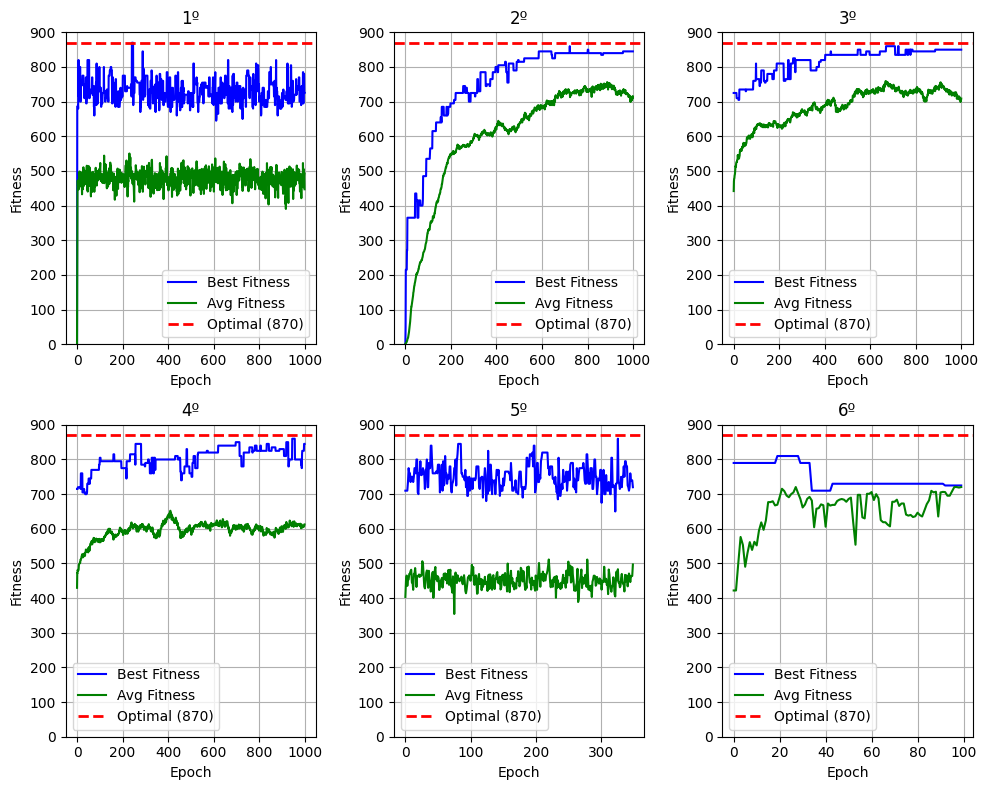

In [292]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

experiment_names = ['1º', '2º', '3º', '4º', '5º', '6º']

for ax, experiment, experiment_name in zip(axes.flatten(), experiment_results, experiment_names):
    exp_data = experiment['data_log']

    print(f"{experiment_name} config: {experiment['config']}")

    # DataFrame com os dados coletados
    columns = ["Epoch", "Best_Fitness", "Avg_Fitness", "Best_Chromosome", "Population_Size", "Fathers_Next_Gen", "Mutation_Prob", "Crossover_Prob", "Warm_Start", "Random_State"]
    df = pd.DataFrame(exp_data, columns=columns)

    ax.plot(df["Epoch"], df["Best_Fitness"], label="Best Fitness", color="blue")
    ax.plot(df["Epoch"], df["Avg_Fitness"], label="Avg Fitness", color="green")
    ax.axhline(y=870, color="red", linestyle="--", linewidth=2, label="Optimal (870)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Fitness")
    ax.set_title(experiment_name)
    ax.set_ylim(0, 900)
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()
